# Benchmark de modelos preentrenados para clasificación

En este trabajo comparamos cuatro modelos preentrenados populares (entrenados con *ImageNet*s): **ResNet18** (nuestro baseline), **EfficientNet** (**B0** y **B3**), **MobileNet_V3_Large** y **ConvNeXt_Tiny**.

En el caso del **ResNet18** baseline, descongelamos únicamente la última capa del backbone para que pueda ajustarse durante el entrenamiento. En los otros tres modelos, el fine-tune se realiza desde capas más tempranas, lo que implica un mayor número de capas entrenables. En resumen, para esta primera parte del trabajo, entrenamos de la siguiente forma:

- ResNet18: desde fc (1 capa entrenable)  
- EfficientNet-B0: desde features.8 (2 capas entrenables)  
- MobileNet V3 Large: desde features.8 (2 capas entrenables)  
- ConvNeXt Tiny: desde features.7 (3 capas entrenables)

Luego, reemplazamos esa capa descongelada por una identidad (`nn.Identity()`), lo que permite conectar un clasificador personalizado compuesto por capas lineales, activaciones y dropout que realiza la clasificación final.

En resumen, el flujo es:

**backbone (capas descongeladas entrenables) → capa identidad → clasificador personalizado**.

Este método aprovecha el aprendizaje transferido del backbone mientras ajusta la salida para nuestras clases específicas.

Para la optimización, consideramos tres valores diferentes de learning rate como principal hiperparámetro a ajustar, dado que los recursos y tiempo disponibles limitan la exploración de otros ajustes.

----------------

La elección de estas arquitecturas se basa en el trabajo *EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks* ([Paper en arXiv](https://arxiv.org/pdf/1905.11946)), así como en el análisis presentado en este [artículo](https://research.google/blog/efficientnet-improving-accuracy-and-efficiency-through-automl-and-model-scaling/). En particular, se seleccionó el modelo **EfficientNet_B0** (utilizado como baseline en dicho estudio) por mostrar un desempeño superior al **ResNet32**, como se ilustra en la siguiente figura (Figura 1 del paper).

Además, se incorporaron los modelos **MobileNet_V3_Large** y **ConvNeXt_Tiny** para ampliar la comparación. MobileNet_V3 también presenta buen desempeño usando *compound scaling* (método desarrollado para balancear profundidad, ancho y resolución de la red de manera eficiente), mientras que ConvNeXt_Tiny es una arquitectura moderna, eficiente y competitiva que no aparece en el estudio original.

Dado el método desarrollado en el estudio de EfficientNet y basado en la mejora de performance lograda mediante *compound scaling* (ver el paper para más detalles), en etapas posteriores se planea extender el análisis a modelos **EfficientNet** más avanzados, como los **B1**, **B3**, y sucesivos.


<img src="https://1.bp.blogspot.com/-oNSfIOzO8ko/XO3BtHnUx0I/AAAAAAAAEKk/rJ2tHovGkzsyZnCbwVad-Q3ZBnwQmCFsgCEwYBhgL/s1600/image3.png" alt="Descripción" height="400">

Configuración preliminar.

In [ ]:
# Recomendado por PyTorch Lightning para aprovechar Tensor Cores (por la arquitectura de mi GPU)
import torch
torch.set_float32_matmul_precision('medium')

import shutil

# Borrar checkpoints anteriores
#shutil.rmtree("checkpoints", ignore_errors=True)

# Borrar logs anteriores
#shutil.rmtree("lightning_logs", ignore_errors=True)

Cargo tensores, creo datasets y creo los dataloaders.

In [19]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Cargar los tensores guardados
X_train, y_train = torch.load("train_normalizado.pt")
X_val, y_val = torch.load("val_normalizado.pt")
X_test, y_test = torch.load("test_normalizado.pt")

# Crear datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Crear loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=False)
val_loader   = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=False)
test_loader  = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=False)

Defino funciones principales para entrenar modelos.

In [10]:
import torch
import torch.nn as nn
from lightning import LightningModule, Trainer
from lightning.pytorch.loggers import CSVLogger
from torchvision import models
import os
from lightning.pytorch.callbacks import EarlyStopping

def get_in_features(base_model):
    base_model.eval()
    with torch.no_grad():
        dummy = torch.randn(1, 3, 224, 224).to(next(base_model.parameters()).device)
        out = base_model(dummy)
    return out.shape[1]

class LitClassifier(LightningModule):
    def __init__(self, base_model_fn, weights, freeze_layer_name, num_classes=3, lr=3e-5):
        super().__init__()
        self.save_hyperparameters()
        self.training_outputs = []
        self.validation_outputs = []

        base_model = base_model_fn(weights=weights)
        unfreeze = False
        for name, param in base_model.named_parameters():
            if freeze_layer_name in name:
                unfreeze = True
            param.requires_grad = unfreeze

        if hasattr(base_model, "fc"):
            base_model.fc = nn.Identity()
            in_features = get_in_features(base_model)
        elif hasattr(base_model, "classifier"):
            base_model.classifier = nn.Identity()
            in_features = get_in_features(base_model)

        self.model = nn.Sequential(
            base_model,
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        self.loss_fn = nn.CrossEntropyLoss()
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, _):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.training_outputs.append(loss.detach())
        return loss  

    def on_train_epoch_end(self):
        avg_loss = torch.stack(self.training_outputs).mean()
        self.log("train_loss", avg_loss, prog_bar=True, on_step=False, on_epoch=True)
        self.training_outputs.clear()

    def validation_step(self, batch, _):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(1) == y).float().mean()
        self.validation_outputs.append({"val_loss": loss.detach(), "val_acc": acc.detach()})
        return None  

    def on_validation_epoch_end(self):
        avg_loss = torch.stack([x["val_loss"] for x in self.validation_outputs]).mean()
        avg_acc = torch.stack([x["val_acc"] for x in self.validation_outputs]).mean()
        self.log("val_loss", avg_loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_acc", avg_acc, prog_bar=True, on_step=False, on_epoch=True)
        self.validation_outputs.clear()
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


def train_and_test_models(train_loader, val_loader, test_loader):
    model_defs = [
        (models.resnet18, models.ResNet18_Weights.DEFAULT, "fc"),
        (models.efficientnet_b0, models.EfficientNet_B0_Weights.DEFAULT, "features.8"),
        (models.mobilenet_v3_large, models.MobileNet_V3_Large_Weights.DEFAULT, "features.8"),
        (models.convnext_tiny, models.ConvNeXt_Tiny_Weights.DEFAULT, "features.7"),
    ]

    learning_rates = [1e-4, 3e-5, 1e-5]

    os.makedirs("checkpoints", exist_ok=True)
    results = {}
    history = {}

    for lr in learning_rates:
        for fn, w, freeze_name in model_defs:
            name = fn.__name__
            print(f"Entrenando {name} con lr={lr}")
            logger = CSVLogger("lightning_logs", name=f"{name}_lr{lr}")
            early_stop_callback = EarlyStopping(
                monitor="val_loss",
                min_delta=0.001,
                patience=5,
                verbose=True,
                mode="min"
            )
                
            model = LitClassifier(fn, w, freeze_name, num_classes=3, lr=lr)
            trainer = Trainer(
                max_epochs=30,
                accelerator="gpu" if torch.cuda.is_available() else "cpu",
                logger=logger,
                callbacks=[early_stop_callback]
            )
            trainer.fit(model, train_loader, val_loader)

            checkpoint_path = f"checkpoints/{name}_lr{lr}_final.ckpt"
            trainer.save_checkpoint(checkpoint_path)

            metrics_df = logger.experiment.metrics
            history[f"{name}_lr{lr}"] = metrics_df

            model.eval()
            all_preds, all_labels = [], []
            for x, y in test_loader:
                x = x.to(model.device)
                with torch.no_grad():
                    preds = model(x).argmax(1)
                    all_preds.append(preds.cpu())
                    all_labels.append(y)
            results[f"{name}_lr{lr}"] = {
                "preds": torch.cat(all_preds),
                "labels": torch.cat(all_labels)
            }

    return results, history

In [ ]:
# Descomentar para ejecutar el entrenamiento
#results, history = train_and_test_models(train_loader, val_loader, test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Entrenando resnet18 con lr=0.0001


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 11.3 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
132 K     Trainable params
11.2 M    Non-trainable params
11.3 M    Total params
45.234    Total estimated model params size (MB)
8         Modules in train mode
68        Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s, v_num=0, val_loss=1.070, val_acc=0.420]

Metric val_loss improved. New best score: 1.070


Epoch 2: 100%|██████████| 27/27 [00:10<00:00,  2.69it/s, v_num=0, val_loss=1.050, val_acc=0.454, train_loss=1.010]

Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 1.054


Epoch 3: 100%|██████████| 27/27 [00:09<00:00,  2.73it/s, v_num=0, val_loss=1.030, val_acc=0.473, train_loss=0.955]

Metric val_loss improved by 0.028 >= min_delta = 0.001. New best score: 1.025


Epoch 4: 100%|██████████| 27/27 [00:10<00:00,  2.63it/s, v_num=0, val_loss=0.990, val_acc=0.471, train_loss=0.903]

Metric val_loss improved by 0.036 >= min_delta = 0.001. New best score: 0.990


Epoch 5: 100%|██████████| 27/27 [00:10<00:00,  2.70it/s, v_num=0, val_loss=0.944, val_acc=0.536, train_loss=0.882]

Metric val_loss improved by 0.046 >= min_delta = 0.001. New best score: 0.944


Epoch 8: 100%|██████████| 27/27 [00:09<00:00,  2.75it/s, v_num=0, val_loss=0.927, val_acc=0.540, train_loss=0.851]

Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.927


Epoch 10: 100%|██████████| 27/27 [00:09<00:00,  2.74it/s, v_num=0, val_loss=0.921, val_acc=0.539, train_loss=0.848]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.921


Epoch 11: 100%|██████████| 27/27 [00:10<00:00,  2.46it/s, v_num=0, val_loss=0.913, val_acc=0.547, train_loss=0.829]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.913


Epoch 14: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s, v_num=0, val_loss=0.907, val_acc=0.550, train_loss=0.818]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.907


Epoch 15: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s, v_num=0, val_loss=0.899, val_acc=0.533, train_loss=0.794]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.899


Epoch 16: 100%|██████████| 27/27 [00:10<00:00,  2.46it/s, v_num=0, val_loss=0.894, val_acc=0.558, train_loss=0.820]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.894


Epoch 18: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s, v_num=0, val_loss=0.855, val_acc=0.592, train_loss=0.818]

Metric val_loss improved by 0.039 >= min_delta = 0.001. New best score: 0.855


Epoch 23: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s, v_num=0, val_loss=0.858, val_acc=0.566, train_loss=0.772]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.855. Signaling Trainer to stop.


Epoch 23: 100%|██████████| 27/27 [00:11<00:00,  2.39it/s, v_num=0, val_loss=0.858, val_acc=0.566, train_loss=0.772]
Entrenando efficientnet_b0 con lr=0.0001


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 4.3 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
740 K     Trainable params
3.6 M     Non-trainable params
4.3 M     Total params
17.345    Total estimated model params size (MB)
8         Modules in train mode
335       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:18<00:00,  1.49it/s, v_num=0, val_loss=1.010, val_acc=0.550]

Metric val_loss improved. New best score: 1.006


Epoch 1: 100%|██████████| 27/27 [00:16<00:00,  1.67it/s, v_num=0, val_loss=0.958, val_acc=0.509, train_loss=1.000]

Metric val_loss improved by 0.049 >= min_delta = 0.001. New best score: 0.958


Epoch 2: 100%|██████████| 27/27 [00:15<00:00,  1.73it/s, v_num=0, val_loss=0.869, val_acc=0.593, train_loss=0.856]

Metric val_loss improved by 0.088 >= min_delta = 0.001. New best score: 0.869


Epoch 4: 100%|██████████| 27/27 [00:16<00:00,  1.61it/s, v_num=0, val_loss=0.852, val_acc=0.595, train_loss=0.758]

Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: 0.852


Epoch 5: 100%|██████████| 27/27 [00:15<00:00,  1.72it/s, v_num=0, val_loss=0.816, val_acc=0.621, train_loss=0.714]

Metric val_loss improved by 0.036 >= min_delta = 0.001. New best score: 0.816


Epoch 6: 100%|██████████| 27/27 [00:15<00:00,  1.74it/s, v_num=0, val_loss=0.796, val_acc=0.648, train_loss=0.686]

Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.796


Epoch 7: 100%|██████████| 27/27 [00:16<00:00,  1.59it/s, v_num=0, val_loss=0.771, val_acc=0.669, train_loss=0.668]

Metric val_loss improved by 0.025 >= min_delta = 0.001. New best score: 0.771


Epoch 10: 100%|██████████| 27/27 [00:14<00:00,  1.83it/s, v_num=0, val_loss=0.696, val_acc=0.713, train_loss=0.644]

Metric val_loss improved by 0.075 >= min_delta = 0.001. New best score: 0.696


Epoch 14: 100%|██████████| 27/27 [00:14<00:00,  1.81it/s, v_num=0, val_loss=0.688, val_acc=0.705, train_loss=0.608]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.688


Epoch 17: 100%|██████████| 27/27 [00:14<00:00,  1.81it/s, v_num=0, val_loss=0.674, val_acc=0.729, train_loss=0.568]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.674


Epoch 18: 100%|██████████| 27/27 [00:14<00:00,  1.81it/s, v_num=0, val_loss=0.659, val_acc=0.742, train_loss=0.550]

Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.659


Epoch 19: 100%|██████████| 27/27 [00:14<00:00,  1.83it/s, v_num=0, val_loss=0.650, val_acc=0.748, train_loss=0.541]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.650


Epoch 23: 100%|██████████| 27/27 [00:15<00:00,  1.78it/s, v_num=0, val_loss=0.636, val_acc=0.764, train_loss=0.508]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.636


Epoch 25: 100%|██████████| 27/27 [00:14<00:00,  1.82it/s, v_num=0, val_loss=0.625, val_acc=0.758, train_loss=0.509]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.625


Epoch 26: 100%|██████████| 27/27 [00:14<00:00,  1.81it/s, v_num=0, val_loss=0.623, val_acc=0.761, train_loss=0.511]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.623


Epoch 29: 100%|██████████| 27/27 [00:14<00:00,  1.81it/s, v_num=0, val_loss=0.633, val_acc=0.765, train_loss=0.471]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 27/27 [00:15<00:00,  1.80it/s, v_num=0, val_loss=0.633, val_acc=0.765, train_loss=0.471]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Entrenando mobilenet_v3_large con lr=0.0001


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 3.2 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
3.1 M     Trainable params
93.2 K    Non-trainable params
3.2 M     Total params
12.875    Total estimated model params size (MB)
8         Modules in train mode
251       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:12<00:00,  2.13it/s, v_num=0, val_loss=0.844, val_acc=0.611]

Metric val_loss improved. New best score: 0.844


Epoch 1: 100%|██████████| 27/27 [00:12<00:00,  2.11it/s, v_num=0, val_loss=0.790, val_acc=0.644, train_loss=0.932]

Metric val_loss improved by 0.054 >= min_delta = 0.001. New best score: 0.790


Epoch 2: 100%|██████████| 27/27 [00:13<00:00,  2.00it/s, v_num=0, val_loss=0.724, val_acc=0.673, train_loss=0.706]

Metric val_loss improved by 0.066 >= min_delta = 0.001. New best score: 0.724


Epoch 4: 100%|██████████| 27/27 [00:13<00:00,  2.05it/s, v_num=0, val_loss=0.640, val_acc=0.763, train_loss=0.624]

Metric val_loss improved by 0.084 >= min_delta = 0.001. New best score: 0.640


Epoch 7: 100%|██████████| 27/27 [00:13<00:00,  1.99it/s, v_num=0, val_loss=0.637, val_acc=0.763, train_loss=0.557]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.637


Epoch 12: 100%|██████████| 27/27 [00:13<00:00,  2.01it/s, v_num=0, val_loss=1.200, val_acc=0.652, train_loss=0.300]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.637. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 27/27 [00:13<00:00,  1.98it/s, v_num=0, val_loss=1.200, val_acc=0.652, train_loss=0.300]
Entrenando convnext_tiny con lr=0.0001


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 28.0 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
14.5 M    Trainable params
13.5 M    Non-trainable params
28.0 M    Total params
112.065   Total estimated model params size (MB)
8         Modules in train mode
200       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:27<00:00,  0.97it/s, v_num=0, val_loss=0.921, val_acc=0.540]

Metric val_loss improved. New best score: 0.921


Epoch 1: 100%|██████████| 27/27 [00:26<00:00,  1.03it/s, v_num=0, val_loss=0.725, val_acc=0.733, train_loss=0.985]

Metric val_loss improved by 0.196 >= min_delta = 0.001. New best score: 0.725


Epoch 2: 100%|██████████| 27/27 [00:25<00:00,  1.04it/s, v_num=0, val_loss=0.713, val_acc=0.668, train_loss=0.722]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.713


Epoch 3: 100%|██████████| 27/27 [00:25<00:00,  1.04it/s, v_num=0, val_loss=0.694, val_acc=0.711, train_loss=0.663]

Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 0.694


Epoch 4: 100%|██████████| 27/27 [00:25<00:00,  1.04it/s, v_num=0, val_loss=0.622, val_acc=0.782, train_loss=0.567]

Metric val_loss improved by 0.072 >= min_delta = 0.001. New best score: 0.622


Epoch 9: 100%|██████████| 27/27 [00:25<00:00,  1.04it/s, v_num=0, val_loss=1.280, val_acc=0.701, train_loss=0.232]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.622. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 27/27 [00:26<00:00,  1.02it/s, v_num=0, val_loss=1.280, val_acc=0.701, train_loss=0.232]
Entrenando resnet18 con lr=3e-05


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 11.3 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
132 K     Trainable params
11.2 M    Non-trainable params
11.3 M    Total params
45.234    Total estimated model params size (MB)
8         Modules in train mode
68        Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s, v_num=0, val_loss=1.110, val_acc=0.289]

Metric val_loss improved. New best score: 1.112


Epoch 1: 100%|██████████| 27/27 [00:10<00:00,  2.49it/s, v_num=0, val_loss=1.100, val_acc=0.328, train_loss=1.130]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 1.101


Epoch 2: 100%|██████████| 27/27 [00:10<00:00,  2.46it/s, v_num=0, val_loss=1.090, val_acc=0.375, train_loss=1.090]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 1.092


Epoch 3: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s, v_num=0, val_loss=1.070, val_acc=0.413, train_loss=1.070]

Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 1.072


Epoch 6: 100%|██████████| 27/27 [00:11<00:00,  2.45it/s, v_num=0, val_loss=1.070, val_acc=0.421, train_loss=1.010]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 1.071


Epoch 7: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s, v_num=0, val_loss=1.060, val_acc=0.445, train_loss=0.997]

Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 1.056


Epoch 8: 100%|██████████| 27/27 [00:10<00:00,  2.47it/s, v_num=0, val_loss=1.050, val_acc=0.469, train_loss=0.980]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 1.051


Epoch 9: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s, v_num=0, val_loss=1.040, val_acc=0.475, train_loss=0.968]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 1.040


Epoch 11: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s, v_num=0, val_loss=1.030, val_acc=0.480, train_loss=0.975]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 1.031


Epoch 13: 100%|██████████| 27/27 [00:11<00:00,  2.42it/s, v_num=0, val_loss=1.020, val_acc=0.471, train_loss=0.927]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 1.023


Epoch 14: 100%|██████████| 27/27 [00:11<00:00,  2.42it/s, v_num=0, val_loss=0.999, val_acc=0.485, train_loss=0.947]

Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 0.999


Epoch 15: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s, v_num=0, val_loss=0.995, val_acc=0.473, train_loss=0.926]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.995


Epoch 17: 100%|██████████| 27/27 [00:11<00:00,  2.45it/s, v_num=0, val_loss=0.985, val_acc=0.484, train_loss=0.899]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.985


Epoch 18: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s, v_num=0, val_loss=0.981, val_acc=0.482, train_loss=0.894]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.981


Epoch 19: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s, v_num=0, val_loss=0.977, val_acc=0.482, train_loss=0.878]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.977


Epoch 20: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s, v_num=0, val_loss=0.974, val_acc=0.481, train_loss=0.877]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.974


Epoch 23: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s, v_num=0, val_loss=0.967, val_acc=0.504, train_loss=0.879]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.967


Epoch 24: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s, v_num=0, val_loss=0.953, val_acc=0.497, train_loss=0.864]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.953


Epoch 25: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s, v_num=0, val_loss=0.951, val_acc=0.498, train_loss=0.849]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.951


Epoch 29: 100%|██████████| 27/27 [00:11<00:00,  2.39it/s, v_num=0, val_loss=0.940, val_acc=0.505, train_loss=0.846]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.940
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 27/27 [00:11<00:00,  2.35it/s, v_num=0, val_loss=0.940, val_acc=0.505, train_loss=0.846]
Entrenando efficientnet_b0 con lr=3e-05


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 4.3 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
740 K     Trainable params
3.6 M     Non-trainable params
4.3 M     Total params
17.345    Total estimated model params size (MB)
8         Modules in train mode
335       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:15<00:00,  1.77it/s, v_num=0, val_loss=1.060, val_acc=0.509]

Metric val_loss improved. New best score: 1.065


Epoch 1: 100%|██████████| 27/27 [00:15<00:00,  1.79it/s, v_num=0, val_loss=1.040, val_acc=0.549, train_loss=1.080]

Metric val_loss improved by 0.029 >= min_delta = 0.001. New best score: 1.035


Epoch 2: 100%|██████████| 27/27 [00:15<00:00,  1.80it/s, v_num=0, val_loss=1.000, val_acc=0.542, train_loss=1.000]

Metric val_loss improved by 0.031 >= min_delta = 0.001. New best score: 1.005


Epoch 3: 100%|██████████| 27/27 [00:14<00:00,  1.80it/s, v_num=0, val_loss=0.982, val_acc=0.540, train_loss=0.948]

Metric val_loss improved by 0.023 >= min_delta = 0.001. New best score: 0.982


Epoch 4: 100%|██████████| 27/27 [00:15<00:00,  1.78it/s, v_num=0, val_loss=0.972, val_acc=0.548, train_loss=0.926]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.972


Epoch 5: 100%|██████████| 27/27 [00:15<00:00,  1.78it/s, v_num=0, val_loss=0.951, val_acc=0.559, train_loss=0.880]

Metric val_loss improved by 0.021 >= min_delta = 0.001. New best score: 0.951


Epoch 6: 100%|██████████| 27/27 [00:15<00:00,  1.79it/s, v_num=0, val_loss=0.934, val_acc=0.590, train_loss=0.840]

Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.934


Epoch 7: 100%|██████████| 27/27 [00:14<00:00,  1.80it/s, v_num=0, val_loss=0.925, val_acc=0.587, train_loss=0.849]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.925


Epoch 8: 100%|██████████| 27/27 [00:15<00:00,  1.80it/s, v_num=0, val_loss=0.923, val_acc=0.580, train_loss=0.784]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.923


Epoch 9: 100%|██████████| 27/27 [00:15<00:00,  1.79it/s, v_num=0, val_loss=0.911, val_acc=0.578, train_loss=0.780]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.911


Epoch 10: 100%|██████████| 27/27 [00:14<00:00,  1.80it/s, v_num=0, val_loss=0.896, val_acc=0.595, train_loss=0.765]

Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.896


Epoch 11: 100%|██████████| 27/27 [00:15<00:00,  1.80it/s, v_num=0, val_loss=0.883, val_acc=0.588, train_loss=0.734]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.883


Epoch 12: 100%|██████████| 27/27 [00:15<00:00,  1.78it/s, v_num=0, val_loss=0.869, val_acc=0.590, train_loss=0.755]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.869


Epoch 14: 100%|██████████| 27/27 [00:14<00:00,  1.80it/s, v_num=0, val_loss=0.849, val_acc=0.617, train_loss=0.718]

Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.849


Epoch 15: 100%|██████████| 27/27 [00:15<00:00,  1.79it/s, v_num=0, val_loss=0.845, val_acc=0.603, train_loss=0.702]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.845


Epoch 16: 100%|██████████| 27/27 [00:15<00:00,  1.78it/s, v_num=0, val_loss=0.841, val_acc=0.607, train_loss=0.707]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.841


Epoch 17: 100%|██████████| 27/27 [00:15<00:00,  1.80it/s, v_num=0, val_loss=0.838, val_acc=0.606, train_loss=0.704]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.838


Epoch 18: 100%|██████████| 27/27 [00:15<00:00,  1.80it/s, v_num=0, val_loss=0.833, val_acc=0.603, train_loss=0.717]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.833


Epoch 19: 100%|██████████| 27/27 [00:15<00:00,  1.79it/s, v_num=0, val_loss=0.826, val_acc=0.613, train_loss=0.683]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.826


Epoch 20: 100%|██████████| 27/27 [00:14<00:00,  1.82it/s, v_num=0, val_loss=0.815, val_acc=0.605, train_loss=0.680]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.815


Epoch 22: 100%|██████████| 27/27 [00:15<00:00,  1.74it/s, v_num=0, val_loss=0.795, val_acc=0.631, train_loss=0.675]

Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.795


Epoch 24: 100%|██████████| 27/27 [00:15<00:00,  1.79it/s, v_num=0, val_loss=0.788, val_acc=0.656, train_loss=0.664]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.788


Epoch 25: 100%|██████████| 27/27 [00:15<00:00,  1.77it/s, v_num=0, val_loss=0.782, val_acc=0.661, train_loss=0.651]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.782


Epoch 26: 100%|██████████| 27/27 [00:15<00:00,  1.78it/s, v_num=0, val_loss=0.777, val_acc=0.662, train_loss=0.650]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.777


Epoch 27: 100%|██████████| 27/27 [00:15<00:00,  1.77it/s, v_num=0, val_loss=0.769, val_acc=0.663, train_loss=0.644]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.769


Epoch 28: 100%|██████████| 27/27 [00:14<00:00,  1.86it/s, v_num=0, val_loss=0.762, val_acc=0.678, train_loss=0.670]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.762


Epoch 29: 100%|██████████| 27/27 [00:13<00:00,  1.99it/s, v_num=0, val_loss=0.767, val_acc=0.680, train_loss=0.643]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 27/27 [00:13<00:00,  1.97it/s, v_num=0, val_loss=0.767, val_acc=0.680, train_loss=0.643]
Entrenando mobilenet_v3_large con lr=3e-05


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 3.2 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
3.1 M     Trainable params
93.2 K    Non-trainable params
3.2 M     Total params
12.875    Total estimated model params size (MB)
8         Modules in train mode
251       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:13<00:00,  1.98it/s, v_num=0, val_loss=1.030, val_acc=0.397]

Metric val_loss improved. New best score: 1.027


Epoch 1: 100%|██████████| 27/27 [00:13<00:00,  1.95it/s, v_num=0, val_loss=0.904, val_acc=0.527, train_loss=1.040]

Metric val_loss improved by 0.124 >= min_delta = 0.001. New best score: 0.904


Epoch 2: 100%|██████████| 27/27 [00:12<00:00,  2.11it/s, v_num=0, val_loss=0.757, val_acc=0.636, train_loss=0.884]

Metric val_loss improved by 0.147 >= min_delta = 0.001. New best score: 0.757


Epoch 3: 100%|██████████| 27/27 [00:12<00:00,  2.16it/s, v_num=0, val_loss=0.738, val_acc=0.675, train_loss=0.747]

Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 0.738


Epoch 7: 100%|██████████| 27/27 [00:13<00:00,  1.96it/s, v_num=0, val_loss=0.680, val_acc=0.729, train_loss=0.692]

Metric val_loss improved by 0.058 >= min_delta = 0.001. New best score: 0.680


Epoch 8: 100%|██████████| 27/27 [00:13<00:00,  1.98it/s, v_num=0, val_loss=0.652, val_acc=0.738, train_loss=0.676]

Metric val_loss improved by 0.028 >= min_delta = 0.001. New best score: 0.652


Epoch 9: 100%|██████████| 27/27 [00:12<00:00,  2.15it/s, v_num=0, val_loss=0.644, val_acc=0.739, train_loss=0.598]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.644


Epoch 13: 100%|██████████| 27/27 [00:12<00:00,  2.13it/s, v_num=0, val_loss=0.603, val_acc=0.766, train_loss=0.567]

Metric val_loss improved by 0.042 >= min_delta = 0.001. New best score: 0.603


Epoch 18: 100%|██████████| 27/27 [00:13<00:00,  1.97it/s, v_num=0, val_loss=0.648, val_acc=0.734, train_loss=0.535]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.603. Signaling Trainer to stop.


Epoch 18: 100%|██████████| 27/27 [00:13<00:00,  1.94it/s, v_num=0, val_loss=0.648, val_acc=0.734, train_loss=0.535]
Entrenando convnext_tiny con lr=3e-05


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 28.0 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
14.5 M    Trainable params
13.5 M    Non-trainable params
28.0 M    Total params
112.065   Total estimated model params size (MB)
8         Modules in train mode
200       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:27<00:00,  0.98it/s, v_num=0, val_loss=1.080, val_acc=0.455]

Metric val_loss improved. New best score: 1.079


Epoch 1: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s, v_num=0, val_loss=1.020, val_acc=0.465, train_loss=1.080]

Metric val_loss improved by 0.055 >= min_delta = 0.001. New best score: 1.024


Epoch 2: 100%|██████████| 27/27 [00:22<00:00,  1.18it/s, v_num=0, val_loss=0.914, val_acc=0.565, train_loss=0.994]

Metric val_loss improved by 0.110 >= min_delta = 0.001. New best score: 0.914


Epoch 3: 100%|██████████| 27/27 [00:22<00:00,  1.19it/s, v_num=0, val_loss=0.787, val_acc=0.675, train_loss=0.856]

Metric val_loss improved by 0.127 >= min_delta = 0.001. New best score: 0.787


Epoch 4: 100%|██████████| 27/27 [00:22<00:00,  1.20it/s, v_num=0, val_loss=0.753, val_acc=0.700, train_loss=0.761]

Metric val_loss improved by 0.034 >= min_delta = 0.001. New best score: 0.753


Epoch 5: 100%|██████████| 27/27 [00:22<00:00,  1.18it/s, v_num=0, val_loss=0.722, val_acc=0.720, train_loss=0.698]

Metric val_loss improved by 0.031 >= min_delta = 0.001. New best score: 0.722


Epoch 8: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s, v_num=0, val_loss=0.701, val_acc=0.704, train_loss=0.634]

Metric val_loss improved by 0.021 >= min_delta = 0.001. New best score: 0.701


Epoch 9: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s, v_num=0, val_loss=0.699, val_acc=0.716, train_loss=0.563]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.699


Epoch 14: 100%|██████████| 27/27 [00:24<00:00,  1.10it/s, v_num=0, val_loss=0.829, val_acc=0.711, train_loss=0.426]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.699. Signaling Trainer to stop.


Epoch 14: 100%|██████████| 27/27 [00:25<00:00,  1.05it/s, v_num=0, val_loss=0.829, val_acc=0.711, train_loss=0.426]
Entrenando resnet18 con lr=1e-05


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 11.3 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
132 K     Trainable params
11.2 M    Non-trainable params
11.3 M    Total params
45.234    Total estimated model params size (MB)
8         Modules in train mode
68        Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:10<00:00,  2.68it/s, v_num=0, val_loss=1.110, val_acc=0.278]

Metric val_loss improved. New best score: 1.111


Epoch 5: 100%|██████████| 27/27 [00:10<00:00,  2.68it/s, v_num=0, val_loss=1.120, val_acc=0.322, train_loss=1.090]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.111. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 27/27 [00:10<00:00,  2.64it/s, v_num=0, val_loss=1.120, val_acc=0.322, train_loss=1.090]
Entrenando efficientnet_b0 con lr=1e-05


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 4.3 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
740 K     Trainable params
3.6 M     Non-trainable params
4.3 M     Total params
17.345    Total estimated model params size (MB)
8         Modules in train mode
335       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:14<00:00,  1.87it/s, v_num=0, val_loss=1.080, val_acc=0.497]

Metric val_loss improved. New best score: 1.077


Epoch 1: 100%|██████████| 27/27 [00:15<00:00,  1.76it/s, v_num=0, val_loss=1.070, val_acc=0.455, train_loss=1.090]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 1.070


Epoch 2: 100%|██████████| 27/27 [00:16<00:00,  1.66it/s, v_num=0, val_loss=1.060, val_acc=0.433, train_loss=1.070]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 1.061


Epoch 3: 100%|██████████| 27/27 [00:15<00:00,  1.71it/s, v_num=0, val_loss=1.050, val_acc=0.435, train_loss=1.050]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 1.053


Epoch 4: 100%|██████████| 27/27 [00:19<00:00,  1.42it/s, v_num=0, val_loss=1.040, val_acc=0.460, train_loss=1.040]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 1.041


Epoch 5: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s, v_num=0, val_loss=1.030, val_acc=0.462, train_loss=1.020]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 1.031


Epoch 6: 100%|██████████| 27/27 [00:21<00:00,  1.26it/s, v_num=0, val_loss=1.030, val_acc=0.458, train_loss=1.010]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 1.027


Epoch 7: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s, v_num=0, val_loss=1.020, val_acc=0.469, train_loss=0.979]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 1.019


Epoch 8: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s, v_num=0, val_loss=1.010, val_acc=0.467, train_loss=0.966]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 1.013


Epoch 9: 100%|██████████| 27/27 [00:21<00:00,  1.27it/s, v_num=0, val_loss=1.000, val_acc=0.481, train_loss=0.954]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 1.004


Epoch 10: 100%|██████████| 27/27 [00:19<00:00,  1.42it/s, v_num=0, val_loss=0.998, val_acc=0.490, train_loss=0.936]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.998


Epoch 11: 100%|██████████| 27/27 [00:19<00:00,  1.35it/s, v_num=0, val_loss=0.986, val_acc=0.481, train_loss=0.932]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.986


Epoch 12: 100%|██████████| 27/27 [00:20<00:00,  1.31it/s, v_num=0, val_loss=0.983, val_acc=0.471, train_loss=0.913]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.983


Epoch 13: 100%|██████████| 27/27 [00:20<00:00,  1.30it/s, v_num=0, val_loss=0.978, val_acc=0.476, train_loss=0.900]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.978


Epoch 14: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s, v_num=0, val_loss=0.969, val_acc=0.493, train_loss=0.883]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.969


Epoch 15: 100%|██████████| 27/27 [00:20<00:00,  1.29it/s, v_num=0, val_loss=0.967, val_acc=0.485, train_loss=0.872]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.967


Epoch 16: 100%|██████████| 27/27 [00:21<00:00,  1.29it/s, v_num=0, val_loss=0.955, val_acc=0.519, train_loss=0.868]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.955


Epoch 17: 100%|██████████| 27/27 [00:19<00:00,  1.35it/s, v_num=0, val_loss=0.949, val_acc=0.519, train_loss=0.858]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.949


Epoch 18: 100%|██████████| 27/27 [00:20<00:00,  1.33it/s, v_num=0, val_loss=0.946, val_acc=0.518, train_loss=0.845]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.946


Epoch 20: 100%|██████████| 27/27 [00:20<00:00,  1.34it/s, v_num=0, val_loss=0.942, val_acc=0.505, train_loss=0.811]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.942


Epoch 21: 100%|██████████| 27/27 [00:18<00:00,  1.47it/s, v_num=0, val_loss=0.939, val_acc=0.521, train_loss=0.805]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.939


Epoch 22: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s, v_num=0, val_loss=0.931, val_acc=0.539, train_loss=0.800]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.931


Epoch 23: 100%|██████████| 27/27 [00:20<00:00,  1.34it/s, v_num=0, val_loss=0.928, val_acc=0.535, train_loss=0.809]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.928


Epoch 24: 100%|██████████| 27/27 [00:20<00:00,  1.35it/s, v_num=0, val_loss=0.921, val_acc=0.545, train_loss=0.792]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.921


Epoch 29: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s, v_num=0, val_loss=0.915, val_acc=0.547, train_loss=0.771]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.915
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 27/27 [00:22<00:00,  1.23it/s, v_num=0, val_loss=0.915, val_acc=0.547, train_loss=0.771]
Entrenando mobilenet_v3_large con lr=1e-05


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 3.2 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
3.1 M     Trainable params
93.2 K    Non-trainable params
3.2 M     Total params
12.875    Total estimated model params size (MB)
8         Modules in train mode
251       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:16<00:00,  1.61it/s, v_num=0, val_loss=1.090, val_acc=0.266]

Metric val_loss improved. New best score: 1.094


Epoch 1: 100%|██████████| 27/27 [00:16<00:00,  1.62it/s, v_num=0, val_loss=1.070, val_acc=0.398, train_loss=1.090]

Metric val_loss improved by 0.025 >= min_delta = 0.001. New best score: 1.069


Epoch 2: 100%|██████████| 27/27 [00:16<00:00,  1.67it/s, v_num=0, val_loss=1.030, val_acc=0.416, train_loss=1.050]

Metric val_loss improved by 0.038 >= min_delta = 0.001. New best score: 1.031


Epoch 3: 100%|██████████| 27/27 [00:16<00:00,  1.67it/s, v_num=0, val_loss=0.957, val_acc=0.470, train_loss=0.992]

Metric val_loss improved by 0.074 >= min_delta = 0.001. New best score: 0.957


Epoch 4: 100%|██████████| 27/27 [00:15<00:00,  1.70it/s, v_num=0, val_loss=0.926, val_acc=0.458, train_loss=0.902]

Metric val_loss improved by 0.031 >= min_delta = 0.001. New best score: 0.926


Epoch 5: 100%|██████████| 27/27 [00:16<00:00,  1.69it/s, v_num=0, val_loss=0.861, val_acc=0.583, train_loss=0.842]

Metric val_loss improved by 0.065 >= min_delta = 0.001. New best score: 0.861


Epoch 6: 100%|██████████| 27/27 [00:15<00:00,  1.75it/s, v_num=0, val_loss=0.836, val_acc=0.614, train_loss=0.770]

Metric val_loss improved by 0.026 >= min_delta = 0.001. New best score: 0.836


Epoch 7: 100%|██████████| 27/27 [00:15<00:00,  1.77it/s, v_num=0, val_loss=0.829, val_acc=0.610, train_loss=0.764]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.829


Epoch 8: 100%|██████████| 27/27 [00:16<00:00,  1.66it/s, v_num=0, val_loss=0.823, val_acc=0.614, train_loss=0.745]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.823


Epoch 9: 100%|██████████| 27/27 [00:16<00:00,  1.67it/s, v_num=0, val_loss=0.789, val_acc=0.649, train_loss=0.716]

Metric val_loss improved by 0.034 >= min_delta = 0.001. New best score: 0.789


Epoch 13: 100%|██████████| 27/27 [00:15<00:00,  1.76it/s, v_num=0, val_loss=0.767, val_acc=0.652, train_loss=0.674]

Metric val_loss improved by 0.022 >= min_delta = 0.001. New best score: 0.767


Epoch 16: 100%|██████████| 27/27 [00:15<00:00,  1.74it/s, v_num=0, val_loss=0.754, val_acc=0.674, train_loss=0.628]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.754


Epoch 18: 100%|██████████| 27/27 [00:15<00:00,  1.69it/s, v_num=0, val_loss=0.722, val_acc=0.691, train_loss=0.626]

Metric val_loss improved by 0.032 >= min_delta = 0.001. New best score: 0.722


Epoch 20: 100%|██████████| 27/27 [00:16<00:00,  1.67it/s, v_num=0, val_loss=0.713, val_acc=0.709, train_loss=0.628]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.713


Epoch 25: 100%|██████████| 27/27 [00:15<00:00,  1.70it/s, v_num=0, val_loss=0.725, val_acc=0.705, train_loss=0.575]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.713. Signaling Trainer to stop.


Epoch 25: 100%|██████████| 27/27 [00:16<00:00,  1.68it/s, v_num=0, val_loss=0.725, val_acc=0.705, train_loss=0.575]
Entrenando convnext_tiny con lr=1e-05


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 28.0 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
14.5 M    Trainable params
13.5 M    Non-trainable params
28.0 M    Total params
112.065   Total estimated model params size (MB)
8         Modules in train mode
200       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:36<00:00,  0.75it/s, v_num=0, val_loss=1.090, val_acc=0.399]

Metric val_loss improved. New best score: 1.090


Epoch 1: 100%|██████████| 27/27 [00:34<00:00,  0.79it/s, v_num=0, val_loss=1.080, val_acc=0.455, train_loss=1.100]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 1.082


Epoch 2: 100%|██████████| 27/27 [00:34<00:00,  0.78it/s, v_num=0, val_loss=1.070, val_acc=0.503, train_loss=1.080]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 1.070


Epoch 3: 100%|██████████| 27/27 [00:34<00:00,  0.79it/s, v_num=0, val_loss=1.050, val_acc=0.533, train_loss=1.070]

Metric val_loss improved by 0.022 >= min_delta = 0.001. New best score: 1.049


Epoch 4: 100%|██████████| 27/27 [00:34<00:00,  0.78it/s, v_num=0, val_loss=1.000, val_acc=0.535, train_loss=1.040]

Metric val_loss improved by 0.047 >= min_delta = 0.001. New best score: 1.002


Epoch 5: 100%|██████████| 27/27 [00:34<00:00,  0.78it/s, v_num=0, val_loss=0.943, val_acc=0.551, train_loss=0.996]

Metric val_loss improved by 0.059 >= min_delta = 0.001. New best score: 0.943


Epoch 6: 100%|██████████| 27/27 [00:34<00:00,  0.79it/s, v_num=0, val_loss=0.895, val_acc=0.580, train_loss=0.915]

Metric val_loss improved by 0.048 >= min_delta = 0.001. New best score: 0.895


Epoch 7: 100%|██████████| 27/27 [00:34<00:00,  0.78it/s, v_num=0, val_loss=0.851, val_acc=0.599, train_loss=0.828]

Metric val_loss improved by 0.044 >= min_delta = 0.001. New best score: 0.851


Epoch 8: 100%|██████████| 27/27 [00:34<00:00,  0.79it/s, v_num=0, val_loss=0.820, val_acc=0.608, train_loss=0.770]

Metric val_loss improved by 0.031 >= min_delta = 0.001. New best score: 0.820


Epoch 9: 100%|██████████| 27/27 [00:34<00:00,  0.78it/s, v_num=0, val_loss=0.788, val_acc=0.630, train_loss=0.771]

Metric val_loss improved by 0.032 >= min_delta = 0.001. New best score: 0.788


Epoch 10: 100%|██████████| 27/27 [00:33<00:00,  0.79it/s, v_num=0, val_loss=0.759, val_acc=0.664, train_loss=0.701]

Metric val_loss improved by 0.029 >= min_delta = 0.001. New best score: 0.759


Epoch 11: 100%|██████████| 27/27 [00:34<00:00,  0.79it/s, v_num=0, val_loss=0.728, val_acc=0.701, train_loss=0.732]

Metric val_loss improved by 0.031 >= min_delta = 0.001. New best score: 0.728


Epoch 13: 100%|██████████| 27/27 [04:03<00:00,  0.11it/s, v_num=0, val_loss=0.705, val_acc=0.706, train_loss=0.670]

Metric val_loss improved by 0.023 >= min_delta = 0.001. New best score: 0.705


Epoch 14: 100%|██████████| 27/27 [00:26<00:00,  1.04it/s, v_num=0, val_loss=0.702, val_acc=0.720, train_loss=0.670]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.702


Epoch 18: 100%|██████████| 27/27 [00:23<00:00,  1.13it/s, v_num=0, val_loss=0.695, val_acc=0.728, train_loss=0.620]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.695


Epoch 19: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s, v_num=0, val_loss=0.691, val_acc=0.731, train_loss=0.640]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.691


Epoch 21: 100%|██████████| 27/27 [00:23<00:00,  1.13it/s, v_num=0, val_loss=0.673, val_acc=0.739, train_loss=0.606]

Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 0.673


Epoch 23: 100%|██████████| 27/27 [00:24<00:00,  1.09it/s, v_num=0, val_loss=0.660, val_acc=0.747, train_loss=0.604]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.660


Epoch 28: 100%|██████████| 27/27 [00:24<00:00,  1.08it/s, v_num=0, val_loss=0.710, val_acc=0.733, train_loss=0.519]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.660. Signaling Trainer to stop.


Epoch 28: 100%|██████████| 27/27 [00:25<00:00,  1.05it/s, v_num=0, val_loss=0.710, val_acc=0.733, train_loss=0.519]


In [32]:
# Guardar resultados y métricas
import pickle

#torch.save(results, "results.pt")
#torch.save(history, "history.pt")
results = torch.load("results.pt")
history = torch.load("history.pt")

A continuación se muestran la pérdida (**loss**) en entrenamiento y validación, así como la precisión (**accuracy**), todas en función de las épocas. Estos gráficos muestran que, en general, los modelos generalizan bien y no presentan sobreajuste, ya que el *early stopping* con una paciencia de 5 detiene el entrenamiento cuando empieza a aparecer el patrón típico de aumento de la pérdida de validación acompañado de una disminución sostenida de la pérdida de entrenamiento.

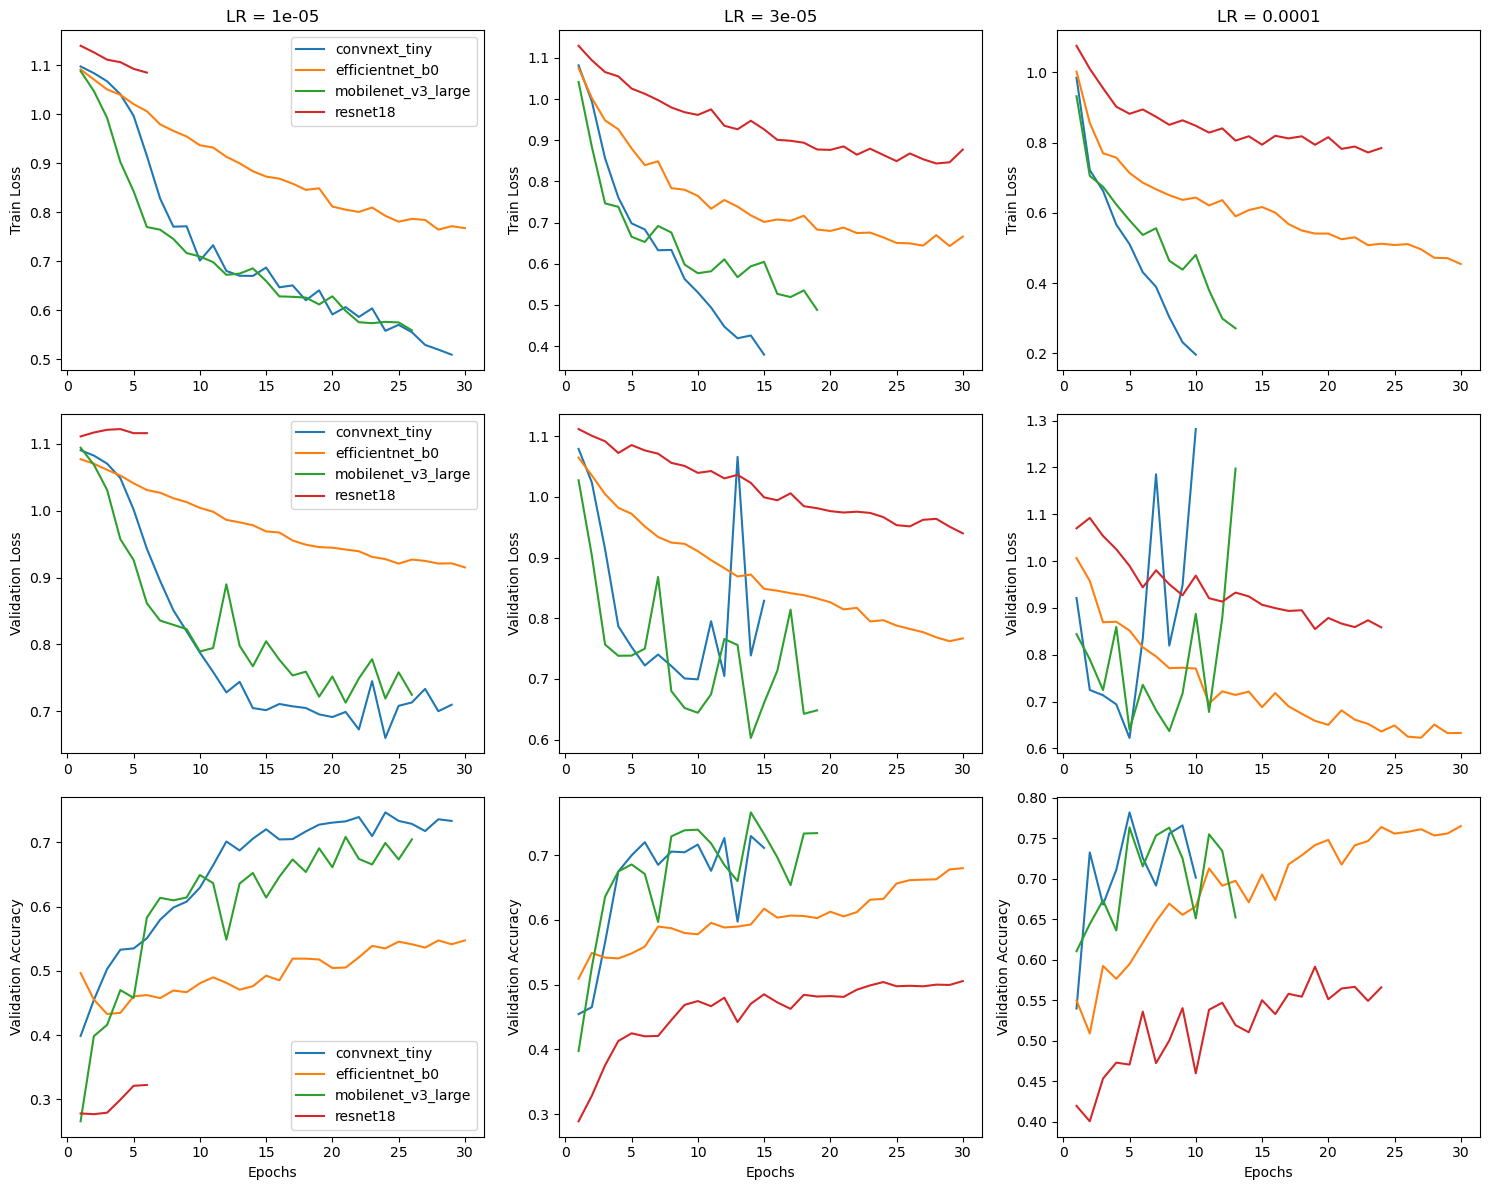

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def load_history_from_logs(log_root="lightning_logs"):
    history = {}
    for folder in os.listdir(log_root):
        folder_path = os.path.join(log_root, folder)
        if not os.path.isdir(folder_path):
            continue
        version_path = os.path.join(folder_path, "version_0", "metrics.csv")
        if os.path.exists(version_path):
            df = pd.read_csv(version_path)
            history[folder] = df
    return history

history = load_history_from_logs()

lrs = sorted({float(k.split("_lr")[1]) for k in history.keys()})
modelos = sorted({k.split("_lr")[0] for k in history.keys()})

fig, axes = plt.subplots(3, len(lrs), figsize=(5*len(lrs), 12), sharex=False)

for col, lr in enumerate(lrs):
    for modelo in modelos:
        if "feature" in modelo:
            continue

        key = f"{modelo}_lr{lr}"
        if key not in history:
            continue

        df = history[key]

        train_loss_df = df[df['train_loss'].notna()]
        val_df = df[df['val_loss'].notna() & df['val_acc'].notna()]

        if not train_loss_df.empty:
            epochs_train = train_loss_df['epoch'] + 1
            train_loss = train_loss_df['train_loss']
            axes[0, col].plot(epochs_train, train_loss, linestyle='-', label=f"{modelo}")

        if not val_df.empty:
            epochs_val = val_df['epoch'] + 1
            val_loss = val_df['val_loss']
            val_acc = val_df['val_acc']
            axes[1, col].plot(epochs_val, val_loss, linestyle='-', label=f"{modelo}")
            axes[2, col].plot(epochs_val, val_acc, linestyle='-', label=f"{modelo}")

    axes[0, col].set_title(f"LR = {lr}")
    axes[0, col].set_ylabel("Train Loss")
    axes[1, col].set_ylabel("Validation Loss")
    axes[2, col].set_ylabel("Validation Accuracy")
    axes[2, col].set_xlabel("Epochs")

for row in range(3):
    axes[row, 0].legend(loc='best')

plt.tight_layout()
plt.show()

## Comparación de modelos con matrices de confusión

A continuación se muestran las matrices de **confusión** para los cuatro modelos, tanto en forma **nominal** como **normalizada**. Se considera el mayor **learning rate** utilizado, ya que es el que ofrece mejores resultados en términos generales, tal como se mostrará al comparar **recall**, **F1** y un **puntaje personalizado**.

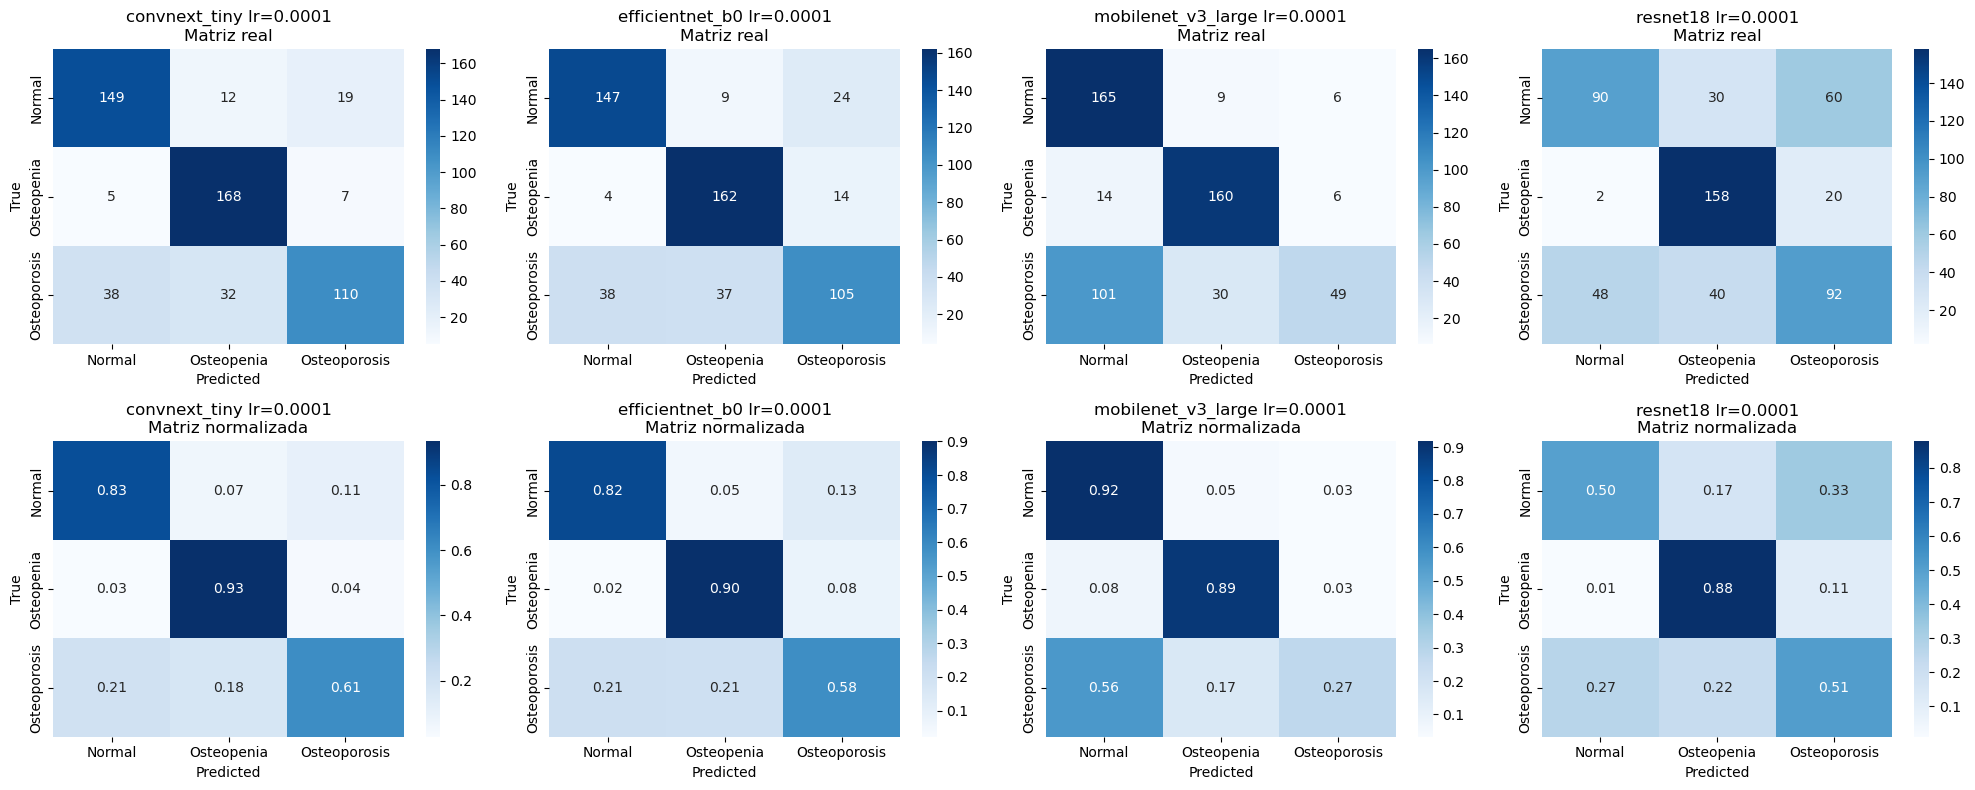

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

lr_target = 1e-4
model_names = sorted({k.split("_lr")[0] for k in results.keys()})

fig, axes = plt.subplots(2, len(model_names), figsize=(5 * len(model_names), 8))

for i, modelo in enumerate(model_names):
    key = f"{modelo}_lr{lr_target}"
    if key not in results:
        print(f"No hay resultados para {key}")
        continue

    y_true = results[key]["labels"].numpy()
    y_pred = results[key]["preds"].numpy()

    # Matriz real
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, i],
                xticklabels=['Normal', 'Osteopenia', 'Osteoporosis'],
                yticklabels=['Normal', 'Osteopenia', 'Osteoporosis'])
    axes[0, i].set_title(f"{modelo} lr={lr_target}\nMatriz real")
    axes[0, i].set_xlabel("Predicted")
    axes[0, i].set_ylabel("True")

    # Matriz normalizada por fila
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", ax=axes[1, i],
                xticklabels=['Normal', 'Osteopenia', 'Osteoporosis'],
                yticklabels=['Normal', 'Osteopenia', 'Osteoporosis'])
    axes[1, i].set_title(f"{modelo} lr={lr_target}\nMatriz normalizada")
    axes[1, i].set_xlabel("Predicted")
    axes[1, i].set_ylabel("True")

plt.tight_layout()
plt.show()


## Métricas adicionales

- **Recall enfermo vs sano:** mide qué tan bien el modelo detecta a los pacientes enfermos (osteopenia u osteoporosis) sin confundirlos con sanos. No distingue entre tipos de enfermedad, solo sano vs enfermo.

- **F1 entre enfermedades:** evalúa el equilibrio entre precisión y recall al clasificar las distintas enfermedades, solo considerando pacientes enfermos. Esta métrica distingue entre osteopenia y osteoporosis.

- **Puntaje diagnóstico:** combinación ponderada del recall general y el F1 específico para enfermedades, para evaluar globalmente el desempeño clínico.


In [34]:
from sklearn.metrics import recall_score, f1_score

# Defino las métricas

def compute_enfermo_vs_sano_recall(y_true, y_pred):
    # Convertir a binario: 0 = Normal, 1 = Enfermo (Osteopenia u Osteoporosis)
    y_true_bin = [0 if x == 0 else 1 for x in y_true]
    y_pred_bin = [0 if x == 0 else 1 for x in y_pred]
    return recall_score(y_true_bin, y_pred_bin)

def compute_enfermedades_f1(y_true, y_pred):
    # Filtro solo los casos enfermos
    y_true_sub = [x for x in y_true if x != 0]
    y_pred_sub = [p for x, p in zip(y_true, y_pred) if x != 0]
    return f1_score(y_true_sub, y_pred_sub, average='macro') 

def diagnostic_score(y_true, y_pred, alpha=0.7, beta=0.3):
    recall = compute_enfermo_vs_sano_recall(y_true, y_pred)
    f1_enf = compute_enfermedades_f1(y_true, y_pred)
    # Combino recall y f1 con pesos alpha y beta
    return alpha * recall + beta * f1_enf

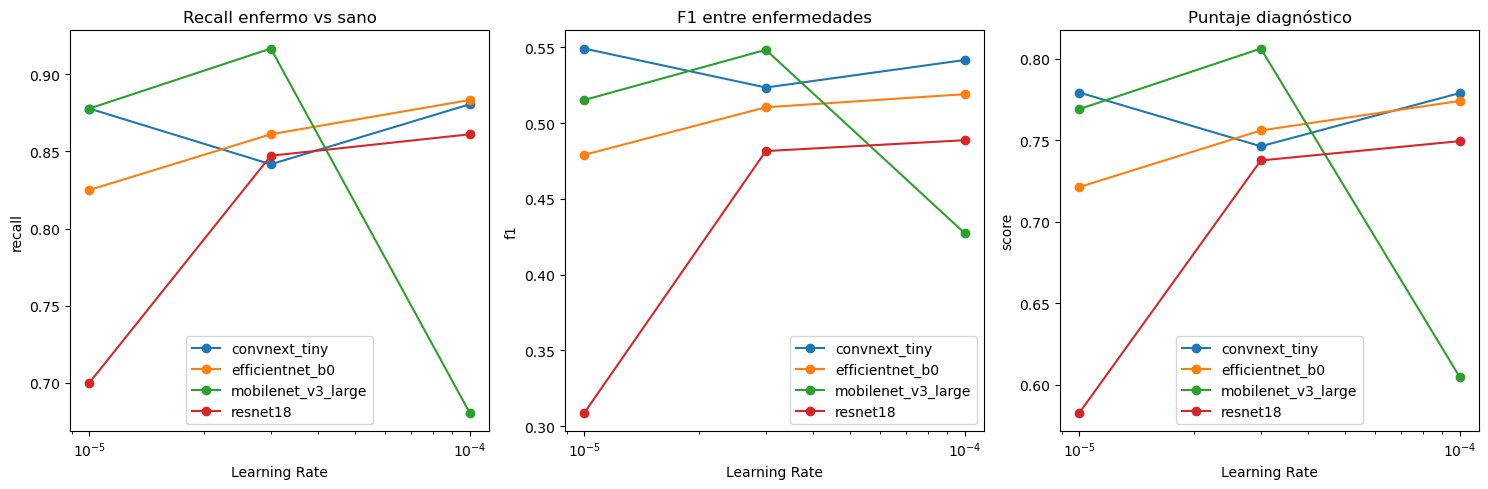

In [14]:
import pandas as pd

# Guardar métricas en lista
data = []
for key, vals in results.items():
    model_name, lr_str = key.split("_lr")
    lr = float(lr_str)
    
    y_true = vals["labels"].numpy()
    y_pred = vals["preds"].numpy()
    
    recall = compute_enfermo_vs_sano_recall(y_true, y_pred)
    f1 = compute_enfermedades_f1(y_true, y_pred)
    score = diagnostic_score(y_true, y_pred)
    
    data.append({
        "modelo": model_name,
        "lr": lr,
        "recall": recall,
        "f1": f1,
        "score": score
    })

df = pd.DataFrame(data)
df = df.sort_values(by=["lr", "modelo"])

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

metricas = ["recall", "f1", "score"]
titulos = ["Recall enfermo vs sano", "F1 entre enfermedades", "Puntaje diagnóstico"]

for ax, metrica, titulo in zip(axes, metricas, titulos):
    for modelo, subdf in df.groupby("modelo"):
        ax.plot(subdf["lr"], subdf[metrica], marker="o", label=modelo)
    ax.set_title(titulo)
    ax.set_xlabel("Learning Rate")
    ax.set_ylabel(metrica)
    ax.set_xscale("log")  
    ax.legend()

plt.tight_layout()
plt.show()


Basado en las tres métricas, el mejor modelo es el **ResNet18**. Este modelo es el más sensible al learning rate elegido, tal como se muestra en los gráficos. En particular, con un learning rate de 1e-4 se obtienen los mejores resultados, pero con el valor intermedio de 3e-5 se consiguen los peores resultados (salvo en el F1).

También se observa que, en **EfficientNet_B0** y **MobileNet_V3_Large**, a medida que aumentamos el learning rate (para los tres valores utilizados), las métricas mejoran. En cambio, para el **ConvNeXt_Tiny** ocurre lo opuesto.

Es importante notar que el modelo con más capas entrenadas (descongeladas) fue el **ResNet18**. Esto podría explicar, en términos generales, por qué obtiene mejores resultados. En particular, la cantidad de capas descongeladas es:

- **ResNet18:** `layer3` (últimas 3 capas del backbone descongeladas + modelo secuencial).
- **EfficientNet_B0:** `features.8` (última capa del backbone descongelada + modelo secuencial).
- **MobileNet_V3_Large:** `features.8` (última capa del backbone descongelada + modelo secuencial).
- **ConvNeXt_Tiny:** `features.7` (última capa del backbone descongelada + modelo secuencial).

Sería conveniente entrenar los modelos descongelando más capas. Además, se podrían considerar otros modelos. Dado que se vio que el mayor learning rate es el que da mejores resultados en 3 de los 4 modelos, será el que se utilice para futuros entrenamientos.

## Nuevos modelos

Pruebo ahora el **EfficientNet_B0** y el **MobilNet_V3_Large** con las dos últimas capas descongeladas. Además, considero el **EfficientNet_B3** con la última capa descongelada. Comparo estos tres modelos con el baseline, es decir, el **ResNet18** con las ultimas 3 capas descongeladas. 
Dado que el mejor resultado en las métricas utilizadas para comparar las predicciones fue con el **leraning rate** de 1e-4, es el único que utilizo en el siguiente análisis.

In [20]:
def train_and_test_new_models(train_loader, val_loader, test_loader):
    model_defs = [
        (models.resnet18, models.ResNet18_Weights.DEFAULT, "fc"),
        (models.resnet18, models.ResNet18_Weights.DEFAULT, "layer3"),
        (models.efficientnet_b3, models.EfficientNet_B3_Weights.DEFAULT, "features.7"),
        (models.mobilenet_v3_large, models.MobileNet_V3_Large_Weights.DEFAULT, "features.6"),
        (models.efficientnet_b0, models.EfficientNet_B0_Weights.DEFAULT, "features.7"),
        (models.efficientnet_b0, models.EfficientNet_B0_Weights.DEFAULT, "features.6"),
    ]

    learning_rates = [1e-4]

    os.makedirs("checkpoints", exist_ok=True)
    results = {}
    history = {}

    for lr in learning_rates:
        for fn, w, freeze_name in model_defs:
            #name = fn.__name__
            name = f"{fn.__name__}_{freeze_name.replace('.', '_')}"
            print(f"Entrenando {name} con lr={lr}")
            #logger = CSVLogger("lightning_logs", name=f"{name}_lr{lr}")
            logger = CSVLogger("lightning_logs", name=f"{name}_lr{lr}")
            early_stop_callback = EarlyStopping(
                monitor="val_loss",
                min_delta=0.001,
                patience=5,
                verbose=True,
                mode="min"
            )
                
            model = LitClassifier(fn, w, freeze_name, num_classes=3, lr=lr)
            trainer = Trainer(
                max_epochs=40,
                accelerator="gpu" if torch.cuda.is_available() else "cpu",
                logger=logger,
                callbacks=[early_stop_callback]
            )
            trainer.fit(model, train_loader, val_loader)

            checkpoint_path = f"checkpoints/{name}_lr{lr}_final.ckpt"
            trainer.save_checkpoint(checkpoint_path)

            metrics_df = logger.experiment.metrics
            history[f"{name}_lr{lr}"] = metrics_df

            model.eval()
            all_preds, all_labels = [], []
            for x, y in test_loader:
                x = x.to(model.device)
                with torch.no_grad():
                    preds = model(x).argmax(1)
                    all_preds.append(preds.cpu())
                    all_labels.append(y)
            results[f"{name}_lr{lr}"] = {
                "preds": torch.cat(all_preds),
                "labels": torch.cat(all_labels)
            }

    return results, history

In [21]:
new_results, new_history = train_and_test_new_models(train_loader, val_loader, test_loader)

torch.save(new_results, "new_results.pt")
torch.save(new_history, "new_history.pt")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Entrenando resnet18_fc con lr=0.0001


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 11.3 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
132 K     Trainable params
11.2 M    Non-trainable params
11.3 M    Total params
45.234    Total estimated model params size (MB)
8         Modules in train mode
68        Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:09<00:00,  2.90it/s, v_num=0, val_loss=1.070, val_acc=0.423]

Metric val_loss improved. New best score: 1.072


Epoch 1: 100%|██████████| 27/27 [00:09<00:00,  2.94it/s, v_num=0, val_loss=1.050, val_acc=0.434, train_loss=1.080]

Metric val_loss improved by 0.022 >= min_delta = 0.001. New best score: 1.050


Epoch 2: 100%|██████████| 27/27 [00:09<00:00,  2.86it/s, v_num=0, val_loss=1.030, val_acc=0.471, train_loss=0.998]

Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 1.026


Epoch 4: 100%|██████████| 27/27 [00:09<00:00,  2.86it/s, v_num=0, val_loss=0.960, val_acc=0.511, train_loss=0.914]

Metric val_loss improved by 0.066 >= min_delta = 0.001. New best score: 0.960


Epoch 5: 100%|██████████| 27/27 [00:09<00:00,  2.79it/s, v_num=0, val_loss=0.940, val_acc=0.512, train_loss=0.885]

Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.940


Epoch 9: 100%|██████████| 27/27 [00:09<00:00,  2.82it/s, v_num=0, val_loss=0.929, val_acc=0.496, train_loss=0.854]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.929


Epoch 10: 100%|██████████| 27/27 [00:09<00:00,  2.87it/s, v_num=0, val_loss=0.879, val_acc=0.550, train_loss=0.874]

Metric val_loss improved by 0.050 >= min_delta = 0.001. New best score: 0.879


Epoch 15: 100%|██████████| 27/27 [00:09<00:00,  2.86it/s, v_num=0, val_loss=0.885, val_acc=0.567, train_loss=0.797]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.879. Signaling Trainer to stop.


Epoch 15: 100%|██████████| 27/27 [00:09<00:00,  2.83it/s, v_num=0, val_loss=0.885, val_acc=0.567, train_loss=0.797]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True


Entrenando resnet18_layer3 con lr=0.0001


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 11.3 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
10.6 M    Trainable params
683 K     Non-trainable params
11.3 M    Total params
45.234    Total estimated model params size (MB)
8         Modules in train mode
68        Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:10<00:00,  2.50it/s, v_num=0, val_loss=0.839, val_acc=0.606]

Metric val_loss improved. New best score: 0.839


Epoch 1: 100%|██████████| 27/27 [00:10<00:00,  2.49it/s, v_num=0, val_loss=0.761, val_acc=0.676, train_loss=0.911]

Metric val_loss improved by 0.078 >= min_delta = 0.001. New best score: 0.761


Epoch 2: 100%|██████████| 27/27 [00:10<00:00,  2.46it/s, v_num=0, val_loss=0.657, val_acc=0.759, train_loss=0.721]

Metric val_loss improved by 0.104 >= min_delta = 0.001. New best score: 0.657


Epoch 5: 100%|██████████| 27/27 [00:10<00:00,  2.50it/s, v_num=0, val_loss=0.602, val_acc=0.767, train_loss=0.622]

Metric val_loss improved by 0.055 >= min_delta = 0.001. New best score: 0.602


Epoch 10: 100%|██████████| 27/27 [00:12<00:00,  2.22it/s, v_num=0, val_loss=1.170, val_acc=0.690, train_loss=0.302]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.602. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 27/27 [00:12<00:00,  2.15it/s, v_num=0, val_loss=1.170, val_acc=0.690, train_loss=0.302]
Entrenando efficientnet_b3_features_7 con lr=0.0001


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 11.1 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
4.3 M     Trainable params
6.8 M     Non-trainable params
11.1 M    Total params
44.362    Total estimated model params size (MB)
8         Modules in train mode
531       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:27<00:00,  0.99it/s, v_num=0, val_loss=0.869, val_acc=0.628]

Metric val_loss improved. New best score: 0.869


Epoch 1: 100%|██████████| 27/27 [00:25<00:00,  1.04it/s, v_num=0, val_loss=0.741, val_acc=0.698, train_loss=0.953]

Metric val_loss improved by 0.128 >= min_delta = 0.001. New best score: 0.741


Epoch 2: 100%|██████████| 27/27 [00:25<00:00,  1.05it/s, v_num=0, val_loss=0.714, val_acc=0.705, train_loss=0.713]

Metric val_loss improved by 0.027 >= min_delta = 0.001. New best score: 0.714


Epoch 4: 100%|██████████| 27/27 [00:25<00:00,  1.06it/s, v_num=0, val_loss=0.702, val_acc=0.723, train_loss=0.603]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.702


Epoch 6: 100%|██████████| 27/27 [00:25<00:00,  1.06it/s, v_num=0, val_loss=0.641, val_acc=0.753, train_loss=0.531]

Metric val_loss improved by 0.061 >= min_delta = 0.001. New best score: 0.641


Epoch 11: 100%|██████████| 27/27 [00:25<00:00,  1.07it/s, v_num=0, val_loss=0.888, val_acc=0.745, train_loss=0.231]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.641. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 27/27 [00:25<00:00,  1.05it/s, v_num=0, val_loss=0.888, val_acc=0.745, train_loss=0.231]
Entrenando mobilenet_v3_large_features_6 con lr=0.0001


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 3.2 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
3.2 M     Trainable params
40.1 K    Non-trainable params
3.2 M     Total params
12.875    Total estimated model params size (MB)
8         Modules in train mode
251       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:14<00:00,  1.92it/s, v_num=0, val_loss=0.759, val_acc=0.672]

Metric val_loss improved. New best score: 0.759


Epoch 1: 100%|██████████| 27/27 [00:13<00:00,  1.94it/s, v_num=0, val_loss=0.691, val_acc=0.701, train_loss=0.939]

Metric val_loss improved by 0.068 >= min_delta = 0.001. New best score: 0.691


Epoch 3: 100%|██████████| 27/27 [00:13<00:00,  1.93it/s, v_num=0, val_loss=0.674, val_acc=0.715, train_loss=0.691]

Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.674


Epoch 4: 100%|██████████| 27/27 [00:14<00:00,  1.92it/s, v_num=0, val_loss=0.672, val_acc=0.714, train_loss=0.650]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.672


Epoch 7: 100%|██████████| 27/27 [00:13<00:00,  1.93it/s, v_num=0, val_loss=0.641, val_acc=0.727, train_loss=0.546]

Metric val_loss improved by 0.031 >= min_delta = 0.001. New best score: 0.641


Epoch 10: 100%|██████████| 27/27 [00:13<00:00,  1.94it/s, v_num=0, val_loss=0.636, val_acc=0.761, train_loss=0.618]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.636


Epoch 14: 100%|██████████| 27/27 [00:13<00:00,  1.93it/s, v_num=0, val_loss=0.613, val_acc=0.774, train_loss=0.618]

Metric val_loss improved by 0.023 >= min_delta = 0.001. New best score: 0.613


Epoch 19: 100%|██████████| 27/27 [00:14<00:00,  1.91it/s, v_num=0, val_loss=0.978, val_acc=0.774, train_loss=0.188]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.613. Signaling Trainer to stop.


Epoch 19: 100%|██████████| 27/27 [00:14<00:00,  1.88it/s, v_num=0, val_loss=0.978, val_acc=0.774, train_loss=0.188]
Entrenando efficientnet_b0_features_7 con lr=0.0001


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 4.3 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
1.5 M     Trainable params
2.9 M     Non-trainable params
4.3 M     Total params
17.345    Total estimated model params size (MB)
8         Modules in train mode
335       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:14<00:00,  1.82it/s, v_num=0, val_loss=0.940, val_acc=0.608]

Metric val_loss improved. New best score: 0.940


Epoch 1: 100%|██████████| 27/27 [00:14<00:00,  1.83it/s, v_num=0, val_loss=0.872, val_acc=0.585, train_loss=0.968]

Metric val_loss improved by 0.067 >= min_delta = 0.001. New best score: 0.872


Epoch 2: 100%|██████████| 27/27 [00:14<00:00,  1.81it/s, v_num=0, val_loss=0.806, val_acc=0.630, train_loss=0.756]

Metric val_loss improved by 0.066 >= min_delta = 0.001. New best score: 0.806


Epoch 3: 100%|██████████| 27/27 [00:14<00:00,  1.81it/s, v_num=0, val_loss=0.748, val_acc=0.685, train_loss=0.698]

Metric val_loss improved by 0.059 >= min_delta = 0.001. New best score: 0.748


Epoch 6: 100%|██████████| 27/27 [00:14<00:00,  1.84it/s, v_num=0, val_loss=0.686, val_acc=0.724, train_loss=0.648]

Metric val_loss improved by 0.062 >= min_delta = 0.001. New best score: 0.686


Epoch 7: 100%|██████████| 27/27 [00:15<00:00,  1.78it/s, v_num=0, val_loss=0.672, val_acc=0.729, train_loss=0.630]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.672


Epoch 8: 100%|██████████| 27/27 [00:15<00:00,  1.78it/s, v_num=0, val_loss=0.651, val_acc=0.732, train_loss=0.631]

Metric val_loss improved by 0.021 >= min_delta = 0.001. New best score: 0.651


Epoch 9: 100%|██████████| 27/27 [00:14<00:00,  1.81it/s, v_num=0, val_loss=0.641, val_acc=0.766, train_loss=0.603]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.641


Epoch 13: 100%|██████████| 27/27 [00:14<00:00,  1.88it/s, v_num=0, val_loss=0.631, val_acc=0.757, train_loss=0.528]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.631


Epoch 17: 100%|██████████| 27/27 [00:15<00:00,  1.80it/s, v_num=0, val_loss=0.628, val_acc=0.762, train_loss=0.477]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.628


Epoch 19: 100%|██████████| 27/27 [00:15<00:00,  1.78it/s, v_num=0, val_loss=0.613, val_acc=0.765, train_loss=0.428]

Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.613


Epoch 21: 100%|██████████| 27/27 [00:14<00:00,  1.81it/s, v_num=0, val_loss=0.568, val_acc=0.776, train_loss=0.394]

Metric val_loss improved by 0.045 >= min_delta = 0.001. New best score: 0.568


Epoch 26: 100%|██████████| 27/27 [00:14<00:00,  1.80it/s, v_num=0, val_loss=0.647, val_acc=0.770, train_loss=0.365]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.568. Signaling Trainer to stop.


Epoch 26: 100%|██████████| 27/27 [00:15<00:00,  1.79it/s, v_num=0, val_loss=0.647, val_acc=0.770, train_loss=0.365]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Entrenando efficientnet_b0_features_6 con lr=0.0001


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 4.3 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
3.5 M     Trainable params
851 K     Non-trainable params
4.3 M     Total params
17.345    Total estimated model params size (MB)
8         Modules in train mode
335       Modules in eval mode


Epoch 0: 100%|██████████| 27/27 [00:16<00:00,  1.60it/s, v_num=0, val_loss=0.997, val_acc=0.499]

Metric val_loss improved. New best score: 0.997


Epoch 1: 100%|██████████| 27/27 [00:16<00:00,  1.64it/s, v_num=0, val_loss=0.729, val_acc=0.680, train_loss=0.870]

Metric val_loss improved by 0.268 >= min_delta = 0.001. New best score: 0.729


Epoch 2: 100%|██████████| 27/27 [00:16<00:00,  1.63it/s, v_num=0, val_loss=0.712, val_acc=0.706, train_loss=0.719]

Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 0.712


Epoch 7: 100%|██████████| 27/27 [00:16<00:00,  1.63it/s, v_num=0, val_loss=0.844, val_acc=0.660, train_loss=0.618]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.712. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 27/27 [00:16<00:00,  1.61it/s, v_num=0, val_loss=0.844, val_acc=0.660, train_loss=0.618]


In [22]:
new_results = torch.load("new_results.pt")
new_history = torch.load("new_history.pt")

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def load_history_from_logs(log_root="lightning_logs"):
    history = {}
    for folder in os.listdir(log_root):
        folder_path = os.path.join(log_root, folder)
        if not os.path.isdir(folder_path):
            continue
        version_path = os.path.join(folder_path, "version_0", "metrics.csv")
        if os.path.exists(version_path):
            df = pd.read_csv(version_path)
            history[folder] = df
    return history

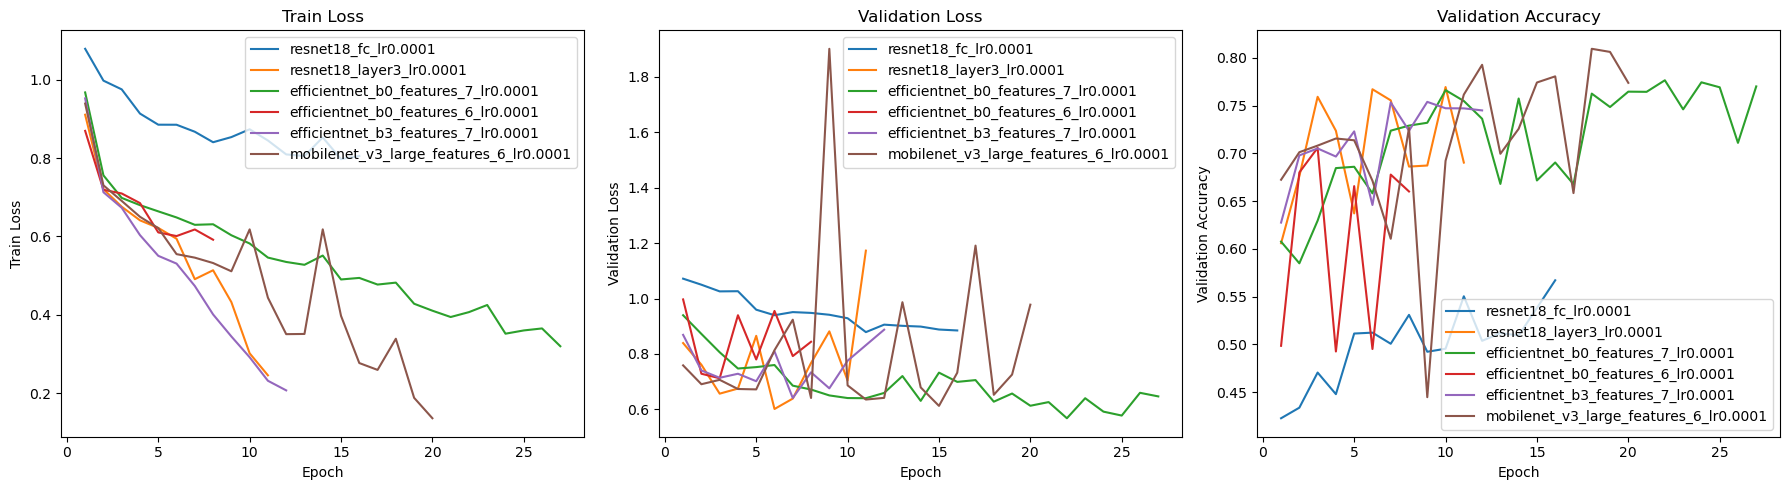

In [30]:

model_folders = [
    "resnet18_fc_lr0.0001",
    "resnet18_layer3_lr0.0001",
    "efficientnet_b0_features_7_lr0.0001",
    "efficientnet_b0_features_6_lr0.0001",
    "efficientnet_b3_features_7_lr0.0001",
    "mobilenet_v3_large_features_6_lr0.0001"
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5)) 

history = load_history_from_logs()

for model in model_folders:
    if model not in history:
        print(f"No encontrado: {model}")
        continue
    df = history[model]
    epochs_train = df.dropna(subset=['train_loss'])['epoch'] + 1
    train_loss = df.dropna(subset=['train_loss'])['train_loss']
    val_df = df.dropna(subset=['val_loss', 'val_acc'])
    epochs_val = val_df['epoch'] + 1
    val_loss = val_df['val_loss']
    val_acc = val_df['val_acc']
    
    axes[0].plot(epochs_train, train_loss, label=model)
    axes[1].plot(epochs_val, val_loss, label=model)
    axes[2].plot(epochs_val, val_acc, label=model)

axes[0].set_title("Train Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Train Loss")

axes[1].set_title("Validation Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Validation Loss")

axes[2].set_title("Validation Accuracy")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Validation Accuracy")

for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

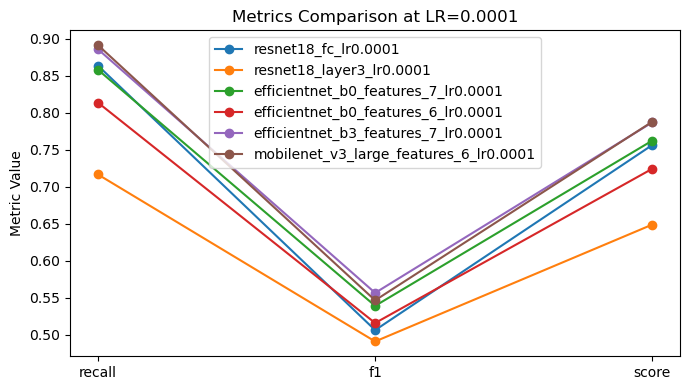

In [37]:
data = []

all_results = {**results, **new_results}

for key, vals in all_results.items():
    lr = float(key.split("_lr")[1])
    y_true = vals["labels"].numpy()
    y_pred = vals["preds"].numpy()
    recall = compute_enfermo_vs_sano_recall(y_true, y_pred)
    f1 = compute_enfermedades_f1(y_true, y_pred)
    score = diagnostic_score(y_true, y_pred)
    data.append({"modelo": key, "lr": lr, "recall": recall, "f1": f1, "score": score})

df = pd.DataFrame(data)
df_lr = df[df["lr"] == 0.0001]

metrics = ["recall", "f1", "score"]
x = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(7,4))

for model in model_folders:
    subdf = df_lr[df_lr["modelo"].str.startswith(model.split("_lr")[0])]
    if subdf.empty:
        continue
    values = [subdf[metric].values[0] for metric in metrics]
    ax.plot(x, values, marker='o', label=model)

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel("Metric Value")
ax.set_title("Metrics Comparison at LR=0.0001")
ax.legend(loc='best')

plt.tight_layout()
plt.show()

No se observaron mejoras respecto al baseline al descongelar más capas ni al usar la versión **EfficientNet_B3**. Se evidenció sobreajuste durante los entrenamientos. Probablemente, sería conveniente implementar **early stopping** para mitigarlo.